<a href="https://colab.research.google.com/github/evpaula/segmentacao-de-clientes-no-varejo-com-xgboost/blob/master/segmentacao_clientes_varejo_com_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neste projeto, vou utilizar o Banco de Dados de Varejo Online, que contém um ano de transações de clientes em um site de comércio eletrônico. O objetivo aqui é classificar um cliente o mais rápido possível para que a equipe de marketing possa enviar as ofertas certas para os clientes certos.



**PARTE 1 : ANALISAR E LIMPAR OS DADOS**

*     Limpando os Dados
*     Análise Exploratória
*     Engenharia de Caraterística
   
    
**PARTE 2 : CRIAR CATEGORIAS DE CLIENTES**

*     Dados Intermediários Agrupados por Invoice
*     Final dataset grouped by customers 
*     K-means Clustering
*     Interpretando os Clusters
    
    
 **PARTE 3 : TESTAR MODELOS DE PREDIÇÃO**
 
*      Modelos Clássicos sklearn
*      Random Forest
*      XGBoost
 


**PARTE 2 : ANALISAR E LIMPAR CLUSTERS**

Importando os Pacotes

In [0]:
# Importação
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

**1.1 Limpando os Dados**

In [0]:
# Importando os Dados 

data = pd.read_csv("/content/drive/My Drive/numerai/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [0]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Let's take a look at the missing values

Text(0.5, 1.0, 'Taxa de Valores Faltantes por Coluna')

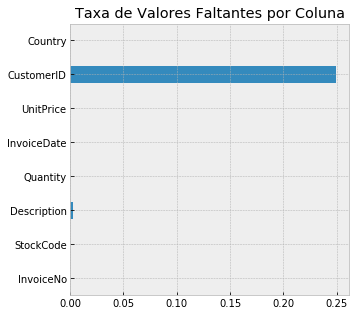

In [0]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Taxa de Valores Faltantes por Coluna")

Vamos nos aprofundar nos valores faltantes

In [0]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


Uma vez que os valores faltantes estão nas colunas CustomerID e Description, posso tentar na coluna InvoiceNo para ver se consigo encontrar o ID dos clientes

In [0]:
data[data['InvoiceNo']== '536414']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom


In [0]:
data[data['InvoiceNo']== '536544'][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


Parece que não podemos subtituir os valores faltantes bem como não podemos mantê-los uma vez que precisamos classificar os clientes. Então, vou pular estas linhas com informações faltantes.

In [0]:
data = data.dropna(subset=["CustomerID"])

Text(0.5, 1.0, 'Taxa de Valores Faltantes por Coluna')

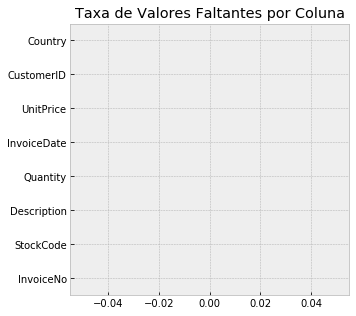

In [0]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Taxa de Valores Faltantes por Coluna")

Não existem mais valores faltantes.
Agora vou conferir se existem valores duplicados e pul-alos também caso existam.

In [0]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


**1.2 Análise Exploratória**

**1.2.1 Países**

In [0]:
data.Country.nunique()

37

In [0]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


Mais de 90% dos dados são provenientes do Reino Unido (UK)

**1.2.2 Quantidade**

In [0]:
data.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [0]:
data[(data['Quantity']<0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


É bem interessante, uma vez que podemos identificar vários insights aqui:
* Os códigos de estoque não são somente numéricos, eles também possuem a letra D que significa Disconto 
* A coluna InvoiceNo também possui valores alfanuméricos, uma vez que para cada valor negativo existe a letra C, isso pode significar que a compra foi cancelada.

Vou analisar a coluna InvoiceNo ara encontra algum padrão.

**1.2.3 InvoiceNo - Código de Cancelamento**

Nesta parte me inspirei nos códigos de um amigo Cientista de Dados brilhante chamado Fabien Daniel para segmentaçãod e clientes.

In [0]:
# Construindo uma cesta para posterior utilização
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [0]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

Parece que mais de 16% das transações foram canceladas, o que é significante. Vamos olhar mais de perto algumas linhas destras transações canceladas.

In [0]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [0]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


Olhando estes resultados, parece que existe uma contrapartida para as transações canceladas no conjunto de dados. Vamos verificar se é sempre este o caso.

In [0]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Nossa hipótese inicial está errada')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Nossa hipótese inicial está errada


In [0]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


Parece que quando há um disconto não há contrapartidas. Vamos verificar quando não há descontos

In [0]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('A segunda hipótese também está errada')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
A segunda hipótese também está errada


In [0]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


Parece que o cliente pode também cancelar apenas uma parte da transação, o que é super normal e lógico. Então temos que levar isso em consideração mais a frente na análise.

In [0]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelamento SEM contrapartida
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelamento COM uma contrapartida
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Várias contrapartidas existentes nos pedidos: vamos deletar a última
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [0]:
print("entradas a remover: {}".format(len(entry_to_remove)))
print("entradas duvidosas: {}".format(len(doubtfull_entry)))

entradas a remover: 6151
entradas duvidosas: 2607


In [0]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("número de entradas a deletar: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

número de entradas a deletar: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [0]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

**1.2.4 Stockcode**

In [0]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

Estas são operações específicas que não caracterizam nossos clientes, então vou só deixar de utilizá-las no nosso conjunto de dados.

In [0]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

**1.2.5 Outliers**

In [0]:
df_cleaned.describe()

,Quantity,UnitPrice,QuantityCanceled
count,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,0.583911
std,181.907403,4.284639,175.868790
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


O valor mínimo da coluna unitprice é 0, vamos ver o motivo.

In [0]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


Estou tentado a substituir os valores nulos pelo mais comum (moda), mas pode ser um desconto especial ou algo mais, então vou deixar assim.
Aqui vamos remover os itens que foram completamente cancelados para harmonizar os clusters futuros e não ter muitos valores especiais.



**1.3 Engenharia de Característica**

In [0]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18405
StockCode :  3659
Description :  3871
Quantity :  300
InvoiceDate :  17169
UnitPrice :  356
CustomerID :  4335
Country :  37
QuantityCanceled :  115


**1.3.1 Total Price**

In [0]:
# Característica "TotalPrice"

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

We can now look at the countries' monetary value thanks to this feature

Text(0.5, 1.0, 'Receita por País')

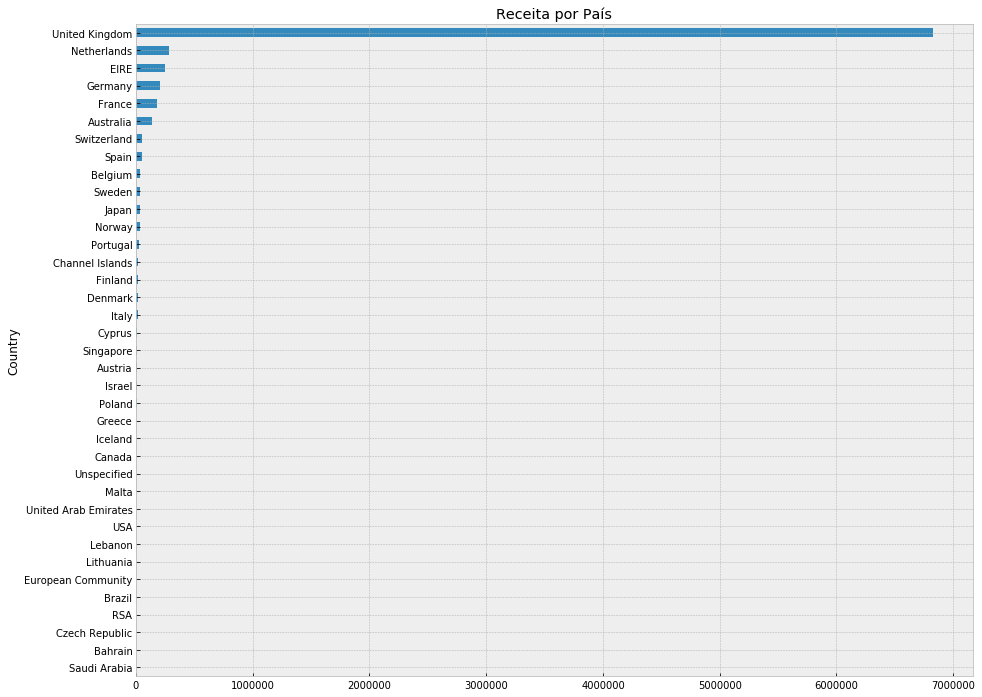

In [0]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Receita por País")

Text(0.5, 1.0, 'Número de Invoices por País')

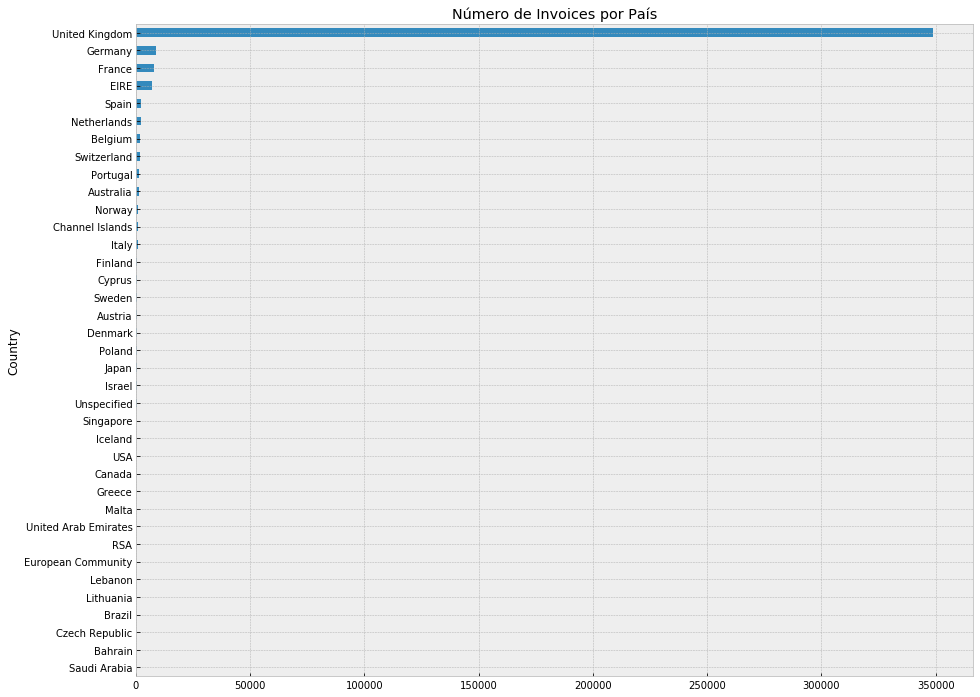

In [0]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Número de Invoices por País")

É muito interessante vermos que a Holanda é o segundo país em valores mesmo que tenha menos invoices emitidas do que países como Alemanha e França com 10 vezes menos clientes.

In [0]:
le = LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [0]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [0]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])

In [0]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [0]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,35,0,20.34


**1.3.2 Princípio RFM**

Vou implementar os princípior RFM para classificar os clientes neste conjunto de dados. Esta parte é inspirada no trabalho de [Susan Li](https://towardsdatascience.com/@actsusanli). RFM significa **Recency, Frequency and Monetary**, trauzindo livremente é a utilização do histórico do comportamento de compras para dividir os clientes em grupos.

In [0]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [0]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [0]:
# Vou apenas fixar a data para ser um dia após a última entrada no banco de dados

NOW = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [0]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [0]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [0]:
rfmTable.head(5)

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [0]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [0]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [0]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12347,2.0,367.0,7,4310.00
12348,75.0,358.0,4,1437.24
12349,18.0,18.0,1,1457.55
12350,310.0,310.0,1,294.40


In [0]:
first_customer = df_cleaned[df_cleaned['CustomerID']=='12747']
first_customer.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,35,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,35,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,35,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,35,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,35,0,32.70


O primeiro cliente comprou muito!

In [0]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [0]:
segmented_rfm = rfmTable_final

In [0]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

Agora vou aplicar um peso a cada característica do RFM

In [0]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1437.24,3,2,2
12349,18.0,18.0,1,1457.55,2,4,2
12350,310.0,310.0,1,294.40,4,4,4


 
Finalmente conseguimos uma pontuação para cada cliente do conjunto de dados.

In [0]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [0]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646,1.0,354.0,73,278742.02,1,1,1,111
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,46,193417.63,1,1,1,111
14911,1.0,373.0,198,131009.71,1,1,1,111
14156,9.0,371.0,54,113728.45,1,1,1,111
17511,2.0,373.0,31,88410.13,1,1,1,111
16684,4.0,358.0,28,66072.76,1,1,1,111
13694,3.0,373.0,50,63101.86,1,1,1,111
15311,0.0,373.0,91,59749.33,1,1,1,111


Aqui nos temos um exemplo de clientes com pontuação 111 que significa que são os nossos clientes mais bem classificados.

In [0]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [0]:
segmented_rfm = segmented_rfm.reset_index()

In [0]:
segmented_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,325.0,325.0,1,0.00,4,4,4,444
1,12347,2.0,367.0,7,4310.00,1,1,1,111
2,12348,75.0,358.0,4,1437.24,3,2,2,322
3,12349,18.0,18.0,1,1457.55,2,4,2,242
4,12350,310.0,310.0,1,294.40,4,4,4,444


In [0]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [0]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

Não precisamos mais das colunas de quartis.

In [0]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

italicized text==> Definição da nossa Pontuação

<a href="https://ibb.co/MpBksbK"><img src="https://i.ibb.co/xGFqDyw/tabela-segmenta-o.png" alt="tabela-segmenta-o" border="0"></a>

**1.3.3 Característica Tempo**

Vou criar algumas características de Tempo, apesar de não utilizá-las, pode ser interessante ver se existe algum padrão de sazonalidade.

In [0]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [0]:
df_cleaned['Month'].value_counts()

11    62949
10    48613
12    42536
9     39510
5     27962
6     26820
3     26752
8     26688
7     26476
4     22347
1     20899
2     19631
Name: Month, dtype: int64

In [0]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [0]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


**1.3.4 Categorias de Produtos**

In [0]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3871, 1694) of float64


In [0]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3871, 100) of float64


In [0]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

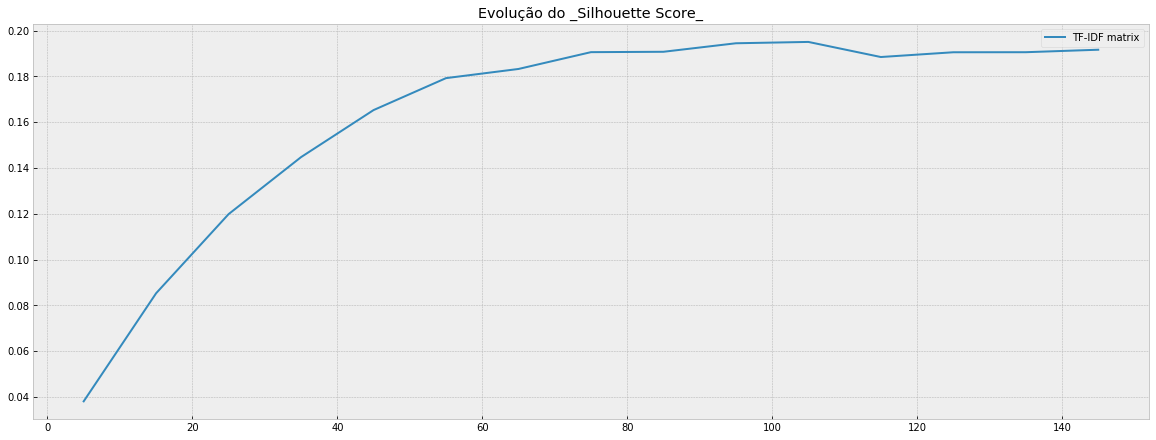

In [0]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolução do _Silhouette Score_")
plt.legend()

O valor mais alto do gráfico é quando tmos 135 clusteres. Então vou escolher este valor.

Text(0.5, 1.0, 'ACP com 135 clusters')

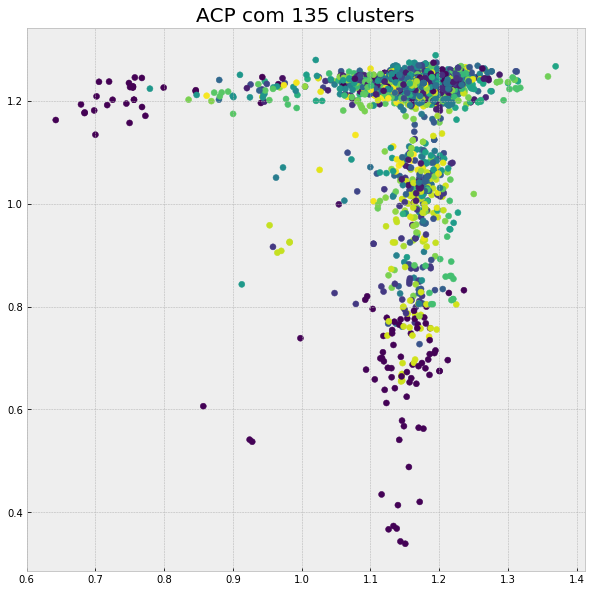

In [0]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP com 135 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualização dos Clusteres com TSNE')

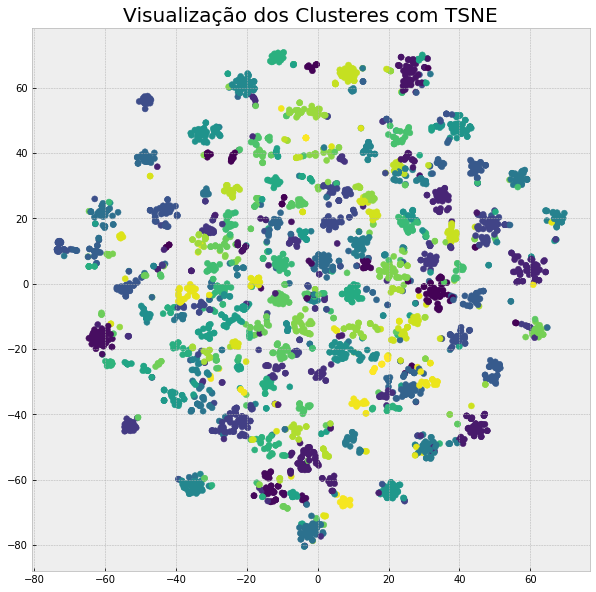

In [0]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualização dos Clusteres com TSNE", fontsize="20")

Everton, O que é [TSNE?](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

<Figure size 432x288 with 0 Axes>

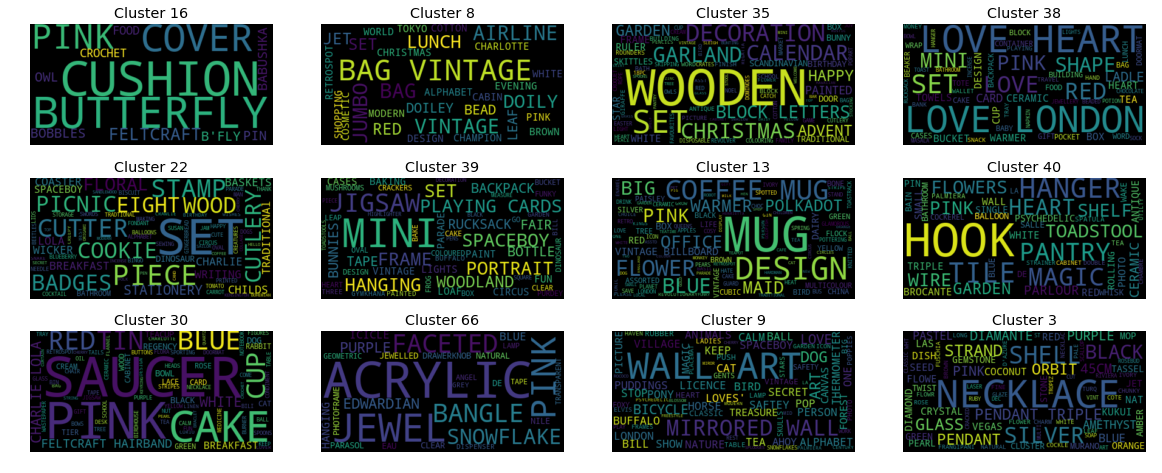

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

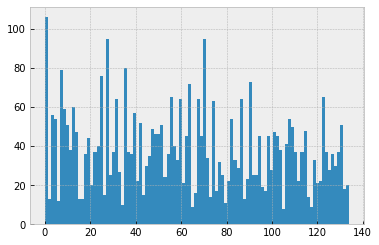

In [0]:
pd.Series(clusters).hist(bins=100)

In [0]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [0]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

**2. Criando Categorias de Clientes**

**2.1 Dados Intermediários agrupados por Invoice**

In [0]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [0]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

**2.2 Conjunto de Dados Final agrupado por Cliente**

In [0]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [0]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [0]:
df_grouped_final.head(5)

TotalPrice                    ... monetary_value Quantity  Country
                  min    max       mean  ...       <lambda>      sum <lambda>
CustomerID                               ...                                 
12346             0.0    0.0   0.000000  ...           0.00    74215       35
12347            13.2   45.0  23.308571  ...        4310.00     2458       16
12348            39.6  150.0  82.840000  ...        1437.24     2332       12
12349            15.0   15.0  15.000000  ...        1457.55      630       18
12350            25.2   25.2  25.200000  ...         294.40      196       24

[5 rows x 9 columns]

In [0]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [0]:
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24


In [0]:
df2_grouped_final.head(5)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,Cluster_30,Cluster_31,Cluster_32,Cluster_33,Cluster_34,Cluster_35,Cluster_36,Cluster_37,Cluster_38,Cluster_39,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104,Cluster_105,Cluster_106,Cluster_107,Cluster_108,Cluster_109,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0
12347,0.000000,0.000000,0.000000,0.0,0.0,0.004037,0.0,0.089722,0.093828,0.0,0.0,0.002367,0.0,0.00000,0.000000,0.0,0.0,0.0,0.003852,0.057912,0.0,0.0,0.0,0.002715,0.0,0.017819,0.0,0.020441,0.002506,0.000000,0.032854,0.000000,0.052343,0.0,0.0,0.015452,0.020882,0.0,0.003884,0.030626,...,0.0,0.006961,0.0,0.000000,0.00000,0.000000,0.0,0.002088,0.0,0.002923,0.0,0.000000,0.000000,0.023596,0.0,0.010970,0.000000,0.0,0.000000,0.00181,0.0,0.018376,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.063258,0.018759,0.006125,0.0,0.0,0.00348,0.0,0.000000,0.004733,0.0,0.0
12348,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.403551,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.188862,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0
12349,0.011938,0.004556,0.074015,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.03923,0.012144,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.023876,0.0,0.120716,0.067922,0.010291,0.000000,0.022641,0.006861,0.0,0.0,0.000000,0.010291,0.0,0.049604,0.004556,...,0.0,0.000000,0.0,0.010188,0.01132,0.022229,0.0,0.000000,0.0,0.027409,0.0,0.008562,0.074989,0.012144,0.0,0.025625,0.011897,0.0,0.006998,0.00000,0.0,0.013584,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.008576,0.017083,0.011320,0.0,0.0,0.00000,0.0,0.013584,0.000000,0.0,0.0
12350,0.000000,0.000000,0.000000,0.0,0.0,0.230299,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.069293,0.134511,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.050951,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0


**2.3 Agrupando(Clusterizando) Clientes**

In [0]:
X1 = df_grouped_final.as_matrix()
X2 = df2_grouped_final.as_matrix()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [0]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.8809213528281707 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8533711829902667 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.2539472558536317 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.29788050272979694 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.3898118866891767 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.3996385618769175 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.403498109625331 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.41033816538721346 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.41023295539427695 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.40865458080817985 with Std Scaling


We want to have at least 5, 6 clusters so we won't take 2 or 3 clusters even though they have the highest silhouette scores, 8 clusters would fit the best here. 

In [0]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

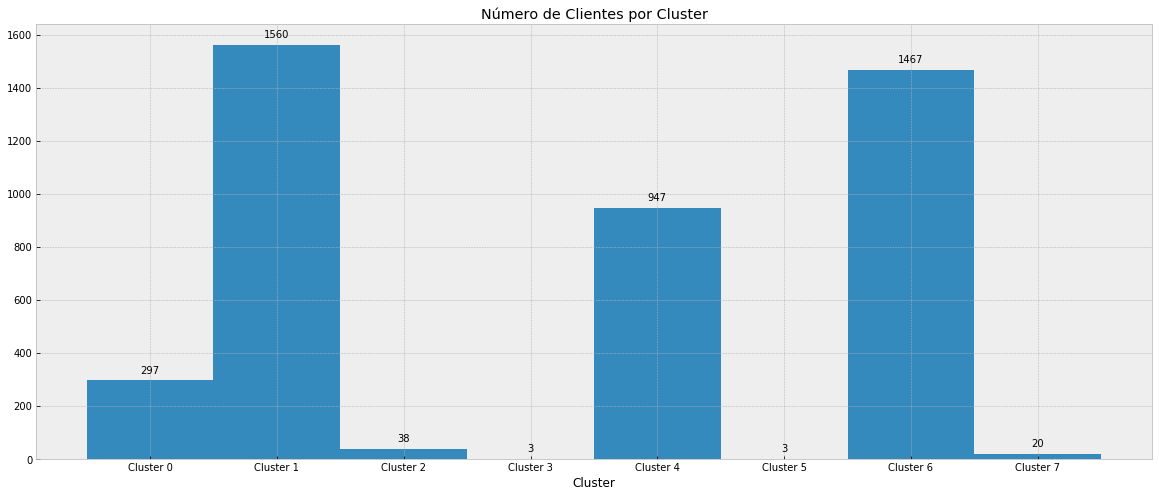

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Número de Clientes por Cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
df_grouped_final["cluster"] = clusters

In [0]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104,Cluster_105,Cluster_106,Cluster_107,Cluster_108,Cluster_109,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,7,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,0,0.000000,0.000000,0.000000,0.0,0.0,0.004037,0.0,0.089722,0.093828,0.0,0.0,0.002367,0.0,0.00000,0.000000,0.0,0.0,0.0,0.003852,0.057912,0.0,0.0,0.0,0.002715,0.0,0.017819,0.0,0.020441,0.002506,0.000000,...,0.0,0.006961,0.0,0.000000,0.00000,0.000000,0.0,0.002088,0.0,0.002923,0.0,0.000000,0.000000,0.023596,0.0,0.010970,0.000000,0.0,0.000000,0.00181,0.0,0.018376,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.063258,0.018759,0.006125,0.0,0.0,0.00348,0.0,0.000000,0.004733,0.0,0.0
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.403551,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.188862,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,0,0.011938,0.004556,0.074015,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.03923,0.012144,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.023876,0.0,0.120716,0.067922,0.010291,...,0.0,0.000000,0.0,0.010188,0.01132,0.022229,0.0,0.000000,0.0,0.027409,0.0,0.008562,0.074989,0.012144,0.0,0.025625,0.011897,0.0,0.006998,0.00000,0.0,0.013584,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.008576,0.017083,0.011320,0.0,0.0,0.00000,0.0,0.013584,0.000000,0.0,0.0
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,4,0.000000,0.000000,0.000000,0.0,0.0,0.230299,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.069293,0.134511,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.050951,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0


In [0]:
final_dataset_V2 = final_dataset.reset_index()

In [0]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [0]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

**2.3 Interpretando os Clusters**

Text(0.5, 1.0, 'Visualização da Clusterização com TSNE')

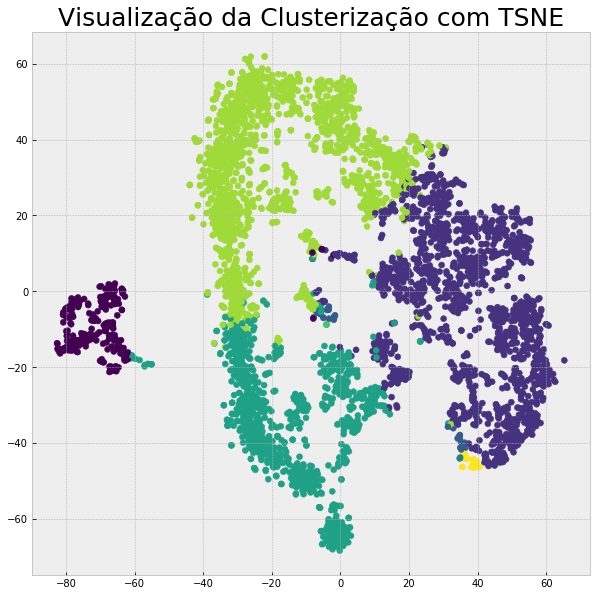

In [0]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualização da Clusterização com TSNE", fontsize="25")

Graficamente os clusteres são suficientemente distintos.

Vamos olhar mais de perto os Clusteres que possuem poucos clientes

**2.3.1. Cluster 0**

In [0]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104,Cluster_105,Cluster_106,Cluster_107,Cluster_108,Cluster_109,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,13.20,45.00,23.308571,2.0,367.0,7,4310.00,2458,16,0,0.000000,0.000000,0.000000,0.0,0.0,0.004037,0.000000,0.089722,0.093828,0.000000,0.0,0.002367,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003852,0.057912,0.000000,0.000000,0.000000,0.002715,0.000000,0.017819,0.0,0.020441,0.002506,0.000000,...,0.000000,0.006961,0.0,0.000000,0.000000,0.000000,0.000000,0.002088,0.000000,0.002923,0.000000,0.000000,0.000000,0.023596,0.000000,0.010970,0.000000,0.000000,0.000000,0.001810,0.000000,0.018376,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.063258,0.018759,0.006125,0.000000,0.000000,0.003480,0.000000,0.000000,0.004733,0.000000,0.000000
12348,39.60,150.00,82.840000,75.0,358.0,4,1437.24,2332,12,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.403551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.188862,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12349,15.00,15.00,15.000000,18.0,18.0,1,1457.55,630,18,0,0.011938,0.004556,0.074015,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.039230,0.012144,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023876,0.0,0.120716,0.067922,0.010291,...,0.000000,0.000000,0.0,0.010188,0.011320,0.022229,0.000000,0.000000,0.000000,0.027409,0.000000,0.008562,0.074989,0.012144,0.000000,0.025625,0.011897,0.000000,0.006998,0.000000,0.000000,0.013584,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008576,0.017083,0.011320,0.000000,0.000000,0.000000,0.000000,0.013584,0.000000,0.000000,0.000000
12353,19.90,19.90,19.900000,204.0,204.0,1,89.00,20,2,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12355,30.00,30.00,30.000000,214.0,214.0,1,459.40,240,2,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.424467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065303,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [0]:
final_dataset[final_dataset['cluster']==0].mean()

min                 22.206633
max                 61.711481
mean                35.501000
min_recency         92.286195
max_recency        222.461279
frequency            3.895623
monetary_value    1915.638283
quantity          1116.966330
country             11.606061
cluster              0.000000
Cluster_0            0.010143
Cluster_1            0.029537
Cluster_2            0.008503
Cluster_3            0.000306
Cluster_4            0.000000
Cluster_5            0.006333
Cluster_6            0.001377
Cluster_7            0.007680
Cluster_8            0.008767
Cluster_9            0.000900
Cluster_10           0.001858
Cluster_11           0.005194
Cluster_12           0.002662
Cluster_13           0.014985
Cluster_14           0.011902
Cluster_15           0.000217
Cluster_16           0.000531
Cluster_17           0.000465
Cluster_18           0.004982
Cluster_19           0.011002
                     ...     
Cluster_105          0.005792
Cluster_106          0.011405
Cluster_10

In [0]:
temp_final_df = final_dataset.reset_index()

In [0]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [0]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              13.825339
UnitPrice              2.895768
QuantityCanceled       0.119567
TotalPrice            23.710964
frequency              7.882809
min_recency           46.563534
monetary_value      4496.144006
dtype: float64

In [0]:
cluster0['Description'].value_counts()[:10]

ROUND SNACK BOXES SET OF4 WOODLAND     233
REGENCY CAKESTAND 3 TIER               163
PLASTERS IN TIN WOODLAND ANIMALS       151
ROUND SNACK BOXES SET OF 4 FRUITS      147
RED TOADSTOOL LED NIGHT LIGHT          145
PLASTERS IN TIN CIRCUS PARADE          143
SPACEBOY LUNCH BOX                     137
PLASTERS IN TIN SPACEBOY               120
RABBIT NIGHT LIGHT                     120
WOODLAND CHARLOTTE BAG                 111
Name: Description, dtype: int64

In [0]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [0]:
cluster0_grouped['RFMScore'].value_counts()

111    32
444    24
211    21
443    17
322    17
122    10
332    10
321    10
343    10
121     9
243     8
221     8
342     8
344     7
222     7
244     6
442     6
144     6
233     6
132     6
433     6
431     5
333     5
223     4
133     4
441     4
432     4
232     3
421     3
231     3
323     3
334     3
123     3
331     3
143     2
423     2
112     2
311     2
341     2
142     1
131     1
212     1
242     1
234     1
324     1
Name: RFMScore, dtype: int64

In [0]:
cluster0_grouped['Country'].value_counts()

14    93
13    86
3     24
18    12
12    12
1      9
6      9
0      8
9      8
7      7
19     6
15     4
5      4
23     3
17     3
22     2
2      2
8      1
11     1
4      1
16     1
10     1
Name: Country, dtype: int64

In [0]:
cluster0['Month'].value_counts()

11    3310
10    3049
9     2184
8     2144
12    2076
6     1893
3     1891
5     1792
7     1757
1     1740
2     1140
4     1019
Name: Month, dtype: int64

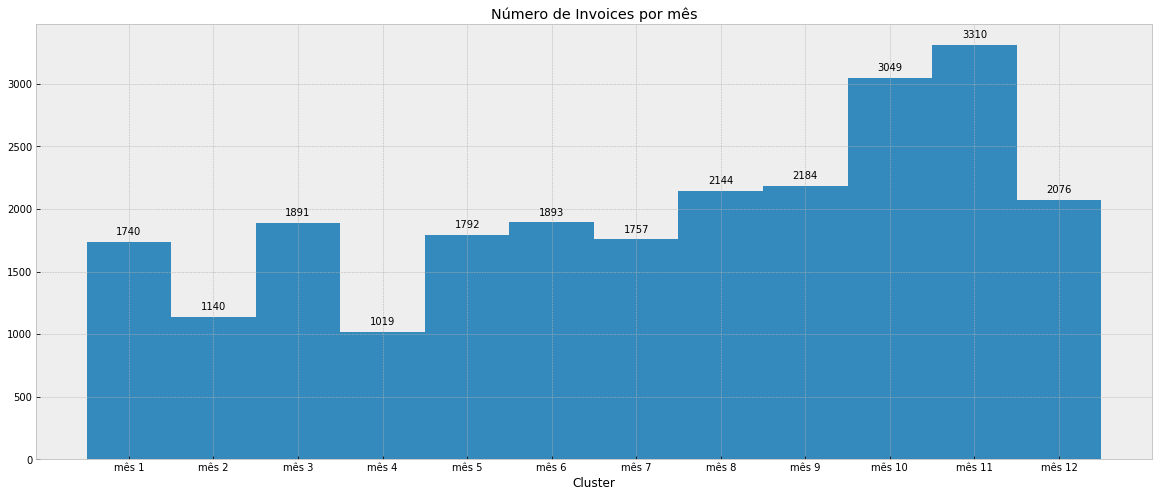

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Número de Invoices por mês")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["mês {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    56
2011.0    30
Name: Year, dtype: int64

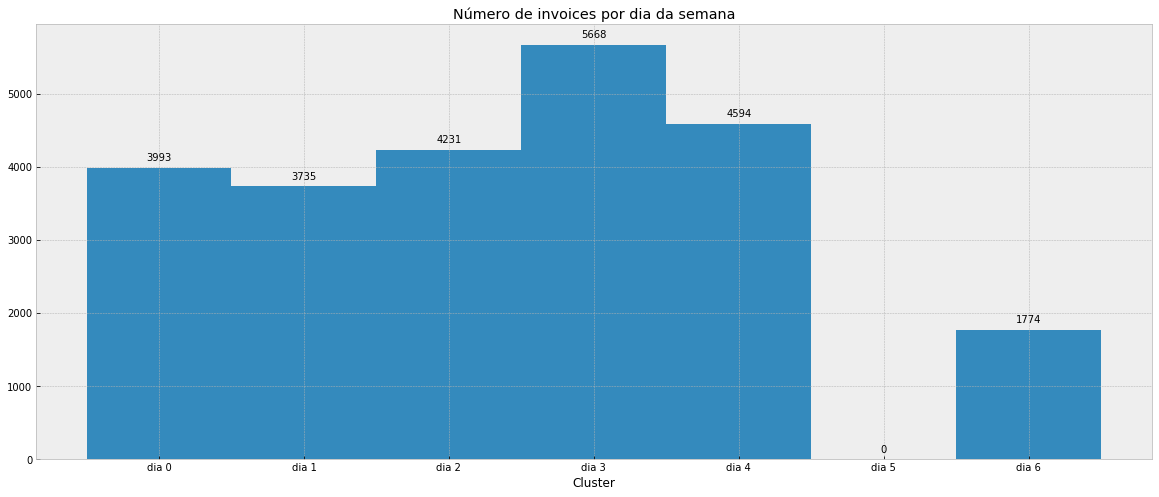

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Número de invoices por dia da semana")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["dia {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
cluster0['Day'].nunique()

31

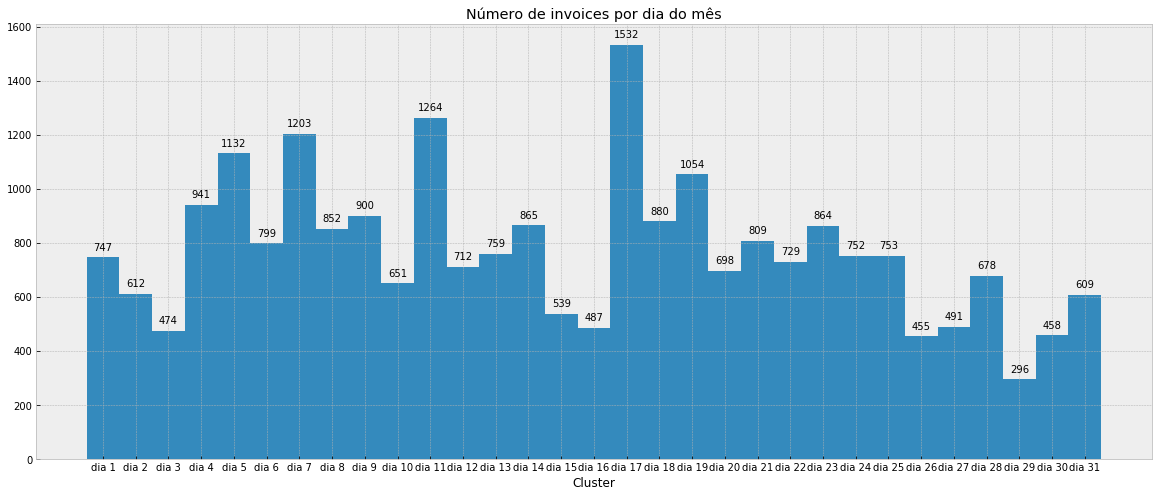

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Número de invoices por dia do mês")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["dia {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [0]:
cluster0['Hour'].nunique()

13

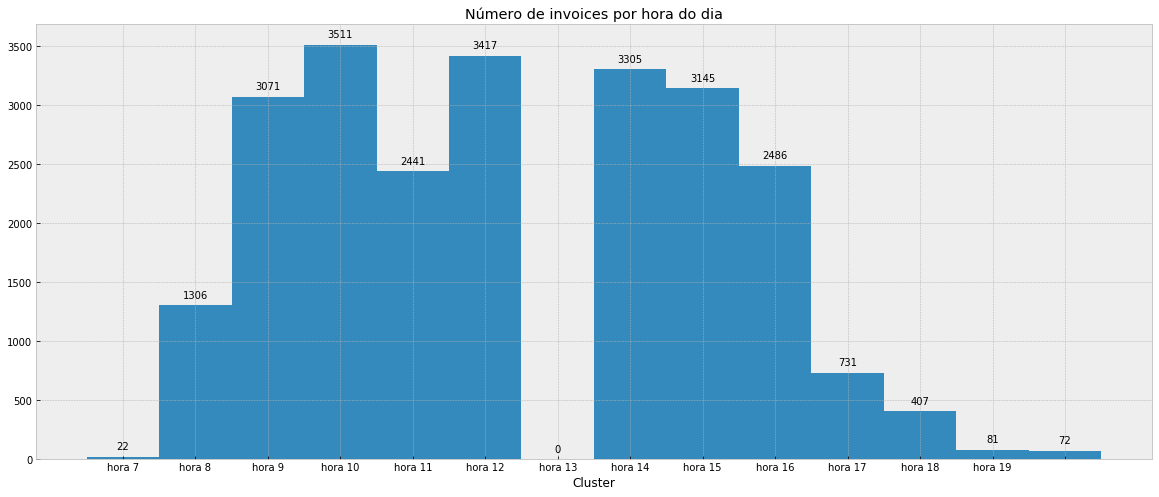

In [0]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Número de invoices por hora do dia")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["hora {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

Esses clientes parecem ser bons para datazone, já que eles têm boas pontuações de RFM, as 4 categorias mais representadas são (111, 211, 322, 222). Eles parecem ser clientes normais. 


Pontos Principais: 
* Min Basket Price: 10.86
* Mean Basket Price: 30.60
* Max Basket Price: 68.57

* Quantity:            10.00
* UnitPrice:           2.87
* QuantityCanceled:     0.04
* TotalPrice:           17.09
* Frequency           11.134050
* Recency         24.574626

TOP 10 produtos comprados :

* WHITE HANGING HEART T-LIGHT HOLDER:    1345
* JUMBO BAG RED RETROSPOT:               1079
* REGENCY CAKESTAND 3 TIER:               960
* ASSORTED COLOUR BIRD ORNAMENT:          926
* PARTY BUNTING:                          924
* LUNCH BAG RED RETROSPOT:                898
* LUNCH BAG  BLACK SKULL:                753
* SET OF 3 CAKE TINS PANTRY DESIGN:       725
* LUNCH BAG CARS BLUE:                    679
* LUNCH BAG PINK POLKADOT:                676

**2.4.2 Cluster 1**

Eu já fiz a mesma análise para os outros clusters, então não vou colocar todo o código aqui, mas a ideia é a mesma

This cluster represents almost lost customers. The weird part about them is that there are some months when they didn't shop at all, it looks like a pattern. 


Pontos Principais: 
* Min Basket Price: 20.83
* Mean Basket Price: 33.77
* Max Basket Price: 26.43

* Quantity:            9.06
* UnitPrice:           2.68
* QuantityCanceled:     0.02
* TotalPrice:           13.77
* Frequency            3.065758
* Recency         36.131902

TOP 10 produtos comprados:

* PAPER CHAIN KIT 50'S CHRISTMAS:        267
* BAKING SET 9 PIECE RETROSPOT:          263
* WHITE HANGING HEART T-LIGHT HOLDER:    250
* ASSORTED COLOUR BIRD ORNAMENT:         247
* REX CASH+CARRY JUMBO SHOPPER:          223
* HOT WATER BOTTLE KEEP CALM:            215
* REGENCY CAKESTAND 3 TIER:              208
* RABBIT NIGHT LIGHT:                    200
* GARDENERS KNEELING PAD KEEP CALM:      194
* SPOTTY BUNTING:                        193

**2.4.3 Cluster 2**

O cluster 2 representa os melhores clientes com alta recência que têm cerca de 60 visitas, muita quantidade comprada em média, um alto valor de monarquia e também uma alta frequência em torno de 60 visitas. Esses clientes devem ser cuidados.

* Min Basket Price : 13
* Mean Basket Price : 513
* Max Basket Price : 3812
* Quantity            117.083422
* UnitPrice             2.830180
* QuantityCanceled      0.069282
* TotalPrice          258.683970
* frequency            67.812655
* min_recency           1.679039

**2.4.4 Cluster 3**

Este cluster está cheio de clientes perdidos. De fato, como podemos ver no histograma do mês, quase não há faturas após julho. Podemos ver que há em dezembro, mas é dezembro do ano passado. Portanto, esse cluster é muito ruim para o datazone, eles não querem ter novos clientes lá. Além disso, eles são clientes baratos, já que o preço médio da cesta é de US $ 28,91 ... 



Pontos Principais: 
* Min Basket Price: 24.20
* Mean Basket Price: 28.91
* Max Basket Price: 34.52

* Quantity:            8.25
* UnitPrice:           3.29
* QuantityCanceled:     0.04
* TotalPrice:          15.20
* Frequency             2.606359
* Recency         237.013433

TOP 10 produtos comprados :

* WHITE HANGING HEART T-LIGHT HOLDER:    227
* REGENCY CAKESTAND 3 TIER:              182
* PARTY BUNTING:                         137
* ASSORTED COLOUR BIRD ORNAMENT:         125
* REX CASH+CARRY JUMBO SHOPPER:          103
* SET OF 3 CAKE TINS PANTRY DESIGN:      100
* NATURAL SLATE HEART CHALKBOARD:        100
* JAM MAKING SET WITH JARS:               99
* HEART OF WICKER SMALL:                  98
* HEART OF WICKER LARGE:                  86

**2.4.5 Cluster 4**

Esse cluster é bastante heterogêneo, pois há 17 melhores clientes, 6 clientes perdidos e assim por diante. Eles têm um preço médio alto de 505, mas é principalmente devido à quantidade média que eles compram (130) porque o preço unitário médio é muito baixo (3,26).

Para as características do tempo, o interessante é que esses clientes compram menos no fim de semana e compram mais no final do ano.

* Min Basket Price : 247
* Mean Basket Price : 505
* Max Basket Price : 1023
* Quantity            130.299145
* UnitPrice             3.264359
* QuantityCanceled      2.332590
* TotalPrice          184.308595

TOP 10 produtos comprados :

* JUMBO BAG RED RETROSPOT :               38
* BLACK RECORD COVER FRAME :            31
* RECORD FRAME 7" SINGLE SIZE :         28
* REGENCY CAKESTAND 3 TIER :           25
* WORLD WAR 2 GLIDERS ASSTD DESIGNS :    24
* WHITE HANGING HEART T-LIGHT HOLDER :   24
* PARTY BUNTING :                        24
* LUNCH BOX I LOVE LONDON :               23
* RED  HARMONICA IN BOX :                23
* CHILLI LIGHTS :                        23

**2.4.6 Cluster 5**

O cluster 5 contém 3 clientes que são muito parecidos. Na verdade, eles compraram apenas uma ou duas vezes alguns itens em grande quantidade. Pode ser alguns profesionários que compraram com desconto e vão vender de volta a commodity. Mesmo que eles tenham um alto valor monetário, eles não são muito interessantes para a Datazon e podemos considerá-los como clientes perdidos.

* Min Basket Price : 3368
* Mean Basket Price : 3697
* Max Basket Price : 3533
* Quantity            2213.777778
* UnitPrice              2.386667
* QuantityCanceled       0.000000
* TotalPrice          3890.091111
* Frequency              1.666667
* Min_recency          210.888889

**2.4.7 Cluster 6**

O que é muito específico sobre este cluster é que não há clientes do Reino Unido, apenas países estrangeiros (Alemanha, França, Bélgica, Itália e Finlândia).
Esse cluster também é heterogêneo em termos de RFM, já que as duas categorias mais representadas são Melhor cliente e Cliente barato perdido. A cesta média é muito baixa (33) comparando as acima, mas eu acho que quanto mais clientes tivermos em um cluster e mais o cliente médio estiver representado, o que não gastou 500 $ por transações como as acima.

Outubro e novembro têm a maioria das invoices que não é surpreendente se aproximando do Natal. 

Pontos Principais: 
* Min Basket Price: 20.58
* Mean Basket Price: 33.55
* Max Basket Price: 59.31

* Quantity:            13.785663
* UnitPrice:           2.884687
* QuantityCanceled:     0.057975
* TotalPrice:          23.749951
* Frequency            7.865563
* Recency         46.622343

TOP 10 produtos comprados :

* ROUND SNACK BOXES SET OF4 WOODLAND:     233
* REGENCY CAKESTAND 3 TIER:               161
* PLASTERS IN TIN WOODLAND ANIMALS:       150
* ROUND SNACK BOXES SET OF 4 FRUITS:      146
* RED TOADSTOOL LED NIGHT LIGHT:          144
* PLASTERS IN TIN CIRCUS PARADE:          141
* SPACEBOY LUNCH BOX:                     137
* RABBIT NIGHT LIGHT:                     120
* PLASTERS IN TIN SPACEBOY:               120
* WOODLAND CHARLOTTE BAG:                 111

**2.4.8 Cluster 7**

O cluster 7 contém 19 clientes que são considerados os melhores clientes, já que são os mais frequentes, com muita frequência (75) e recentemente. A diferença com o cluster 2 é que os clientes do cluster 7 compram com mais freqüência (75 x 60), mas possuem um valor monetário menor (58.000 x 249.000).
Eles têm um preço médio de cesta menor do que os outros clusters.

* Min Basket Price : 10
* Mean Basket Price : 138
* Max Basket Price : 648
* Quantity            23.257769
* UnitPrice            2.615444
* QuantityCanceled     0.109129
* TotalPrice          34.916436
* Frequency           121.570291
* Recency           2.599109

TOP 10 produtos comprados :

* REGENCY CAKESTAND 3 TIER:              136
* JUMBO BAG RED RETROSPOT:               135
* WHITE HANGING HEART T-LIGHT HOLDER:    121
* CHILLI LIGHTS:                         102
* PAPER BUNTING RETROSPOT:                97
* LUNCH BAG  BLACK SKULL:                95
* GUMBALL COAT RACK:                      93
* LUNCH BAG RED RETROSPOT:                91
* JUMBO BAG PINK POLKADOT:                84
* LUNCH BAG CARS BLUE:                    81

**2.4.9 Conclusão**

Vamos rapidamente classificar os clusters em termos de importância para o Datazon :

- **Cluster 2**: Alta frequência com muita quantidade (preço médio de cesta de 513) comprada em média e alto valor monetário (clientes VIP)
- **Cluster 7**: Frequência de compra muito alta com um preço médio de 150, mas bom valor monetário.
- **Cluster 4**: Preço muito alto cesta (enorme quantidade de produtos comprados em média)
- **Cluster 0**: Bons clientes médios
- **Cluster 6**: Bons clientes extrangeiros 
- **Cluster 1**: Clientes quase perdidos
- **Cluster 5**: Maior valor monetário, mas apenas uma ou duas compras ao longo do ano
- **Cluster 3**: Clientes Perdidos 

**3. Testando Modelos de Predição**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime as dt
import pickle
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
new_df = pd.read_csv("final_dataset_V2.csv")

In [0]:
new_df.head(5)

,CustomerID,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104,Cluster_105,Cluster_106,Cluster_107,Cluster_108,Cluster_109,Cluster_110,Cluster_111,Cluster_112,Cluster_113,Cluster_114,Cluster_115,Cluster_116,Cluster_117,Cluster_118,Cluster_119,Cluster_120,Cluster_121,Cluster_122,Cluster_123,Cluster_124,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
0,12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,7,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0
1,12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,0,0.000000,0.000000,0.000000,0.0,0.0,0.004037,0.0,0.089722,0.093828,0.0,0.0,0.002367,0.0,0.00000,0.000000,0.0,0.0,0.0,0.003852,0.057912,0.0,0.0,0.0,0.002715,0.0,0.017819,0.0,0.020441,0.002506,...,0.0,0.006961,0.0,0.000000,0.00000,0.000000,0.0,0.002088,0.0,0.002923,0.0,0.000000,0.000000,0.023596,0.0,0.010970,0.000000,0.0,0.000000,0.00181,0.0,0.018376,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.063258,0.018759,0.006125,0.0,0.0,0.00348,0.0,0.000000,0.004733,0.0,0.0
2,12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.403551,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.188862,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0
3,12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,0,0.011938,0.004556,0.074015,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.03923,0.012144,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.023876,0.0,0.120716,0.067922,...,0.0,0.000000,0.0,0.010188,0.01132,0.022229,0.0,0.000000,0.0,0.027409,0.0,0.008562,0.074989,0.012144,0.0,0.025625,0.011897,0.0,0.006998,0.00000,0.0,0.013584,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.008576,0.017083,0.011320,0.0,0.0,0.00000,0.0,0.013584,0.000000,0.0,0.0
4,12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,4,0.000000,0.000000,0.000000,0.0,0.0,0.230299,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.069293,0.134511,...,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.050951,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0


Preparando as características

In [0]:
X = new_df.drop(columns=['CustomerID', 'cluster']) 
y = new_df['cluster'].values

In [0]:
scaler = StandardScaler() # create scaler object

X_scaled = scaler.fit_transform(X)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size = 0.2,random_state = 0, stratify=y) # Do 80/20 split

**3.1 Testanto Modelos Clássicos**

**3.1.1 Baseline**

In [0]:
from sklearn.dummy import DummyClassifier

In [0]:
dummy_biased = DummyClassifier(random_state=0)

dummy_biased.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='stratified')

In [0]:
print("Baseline accuracy", (dummy_biased.score(X_test, y_test))*100)

Baseline accuracy 28.027681660899656


**3.1.2 Modelos Lineares**

In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [0]:
# Regressão Logística

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Precisão da Regressão Logística:", (lr.score(X_test, y_test))*100)

Precisão da Regressão Logística: 96.53979238754326


In [0]:
# Classificação SGD

SGD = SGDClassifier()
SGD.fit(X_train, y_train)
print("Precisão da Classificação SGD", (SGD.score(X_test, y_test))*100)

Precisão da Classificação SGD 95.15570934256056


**3.1.3 SVM**

In [0]:
# Linear SVC

from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, y_train)
print("Precisão SVM Linear:", (svc.score(X_test, y_test))*100)

Precisão SVM Linear: 95.15570934256056


**3.2 Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfc=RandomForestClassifier(random_state=0, n_estimators = 1000)

In [0]:
param_grid = { 
    'n_estimators' : [100, 500, 1000],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6],
    'criterion' :['gini', 'entropy']
}

CV_rfc_biased = model_selection.GridSearchCV(estimator=rfc_biased, param_grid=param_grid, cv= 5, verbose=10, n_jobs=-1, scoring='accuracy')
CV_rfc_biased.fit(X_train_biased, y_train_biased)

CV_rfc_random.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 1000}

In [0]:
rfc=RandomForestClassifier(random_state=0, n_estimators = 1000, criterion='entropy', max_depth=6, max_features='auto')

In [0]:
rfc.fit(X_train, y_train)
print("Precisão da Classificação Random Forest:", (rfc.score(X_test, y_test)*100))

Precisão da Classificação Random Forest: 93.54094579008074


In [0]:
y_pred = rfc.predict(X_test)

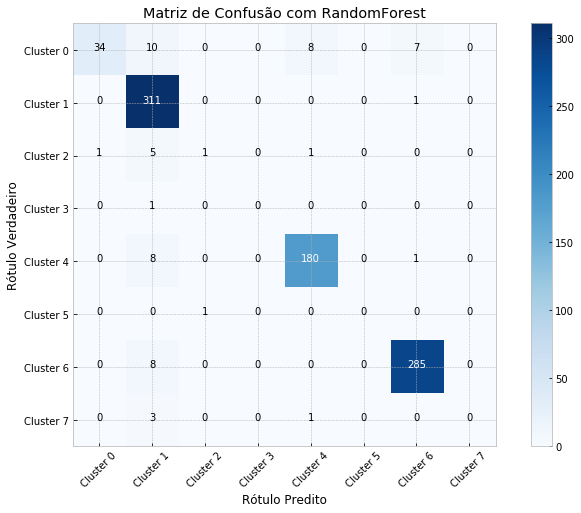

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função plota a matriz de confusão.
    A normalização pode ser aplicada utilizando `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Predito')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ["Cluster {}".format(x) for x in range(8)]

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Matriz de Confusão com RandomForest')

**3.3 XGBoost**

In [0]:
import xgboost

In [0]:
xgb = xgboost.XGBClassifier(random_state = 0, learning_rate = 0.01, 
                                   objective = 'multi:softprob', n_estimators = 1000,
                                  colsample_bytree = 0.6, gamma = 0.5, max_depth = 7,
                                  min_child_weight = 1, subsample=0.8, n_jobs=-1, scoring='accuracy')

In [0]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, scoring='accuracy',
              seed=None, silent=None, subsample=0.8, verbosity=1)

In [0]:
print("Accuracy for XGBoost : ", (xgb.score(X_test, y_test))*100)

Accuracy for XGBoost :  98.0392156862745


In [0]:
y_pred = xgb.predict(X_test)

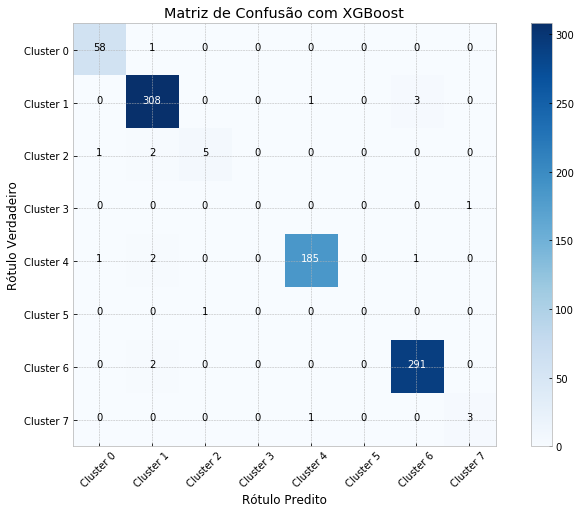

In [0]:
# Cálculo Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Gráfico Matriz de Confusão não-normalizado
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Matriz de Confusão com XGBoost')

In [0]:
# Salvando o melhor modelo

with open('training_algos.pickle', 'wb') as f:
    pickle.dump(xgb, f)

**Eu gostaria de agradecer a todos que chegaram comigo tão longe nessa análise, eu bem sei que este projeto foi abrangente e algumas vezes técnico uma vez que trabalhei com um conjunto de dados bem completo e abrangente. Umas de tantas partes positivas deste projeto foi ter me dado várias ideias de futuras aplicações. Se você tiver ideias de como melhorar as análises, serão sempre bem vindas! Grande abraço e até a próxima!**

![](http://)